## Load Python Libraries

In [37]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from scipy.stats import pearsonr
from PIL import Image

### Get a list of peptides

In [38]:
peptide_score_file = './data/training_peptide_PSSM_scores.txt'

def load_peptide_data(infile):

    peptides = list()
    PSSM_score = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            PSSM_score.append(float(score))

    return peptides, PSSM_score

peptides, PSSM_score = load_peptide_data(peptide_score_file)

## Import Amino acid depiction

In [96]:
amino_acid_full_names = {
    'A': 'alanine',
    'R': 'arginine',
    'N': 'asparagine',
    'D': 'aspartic_acid',
    'C': 'cysteine',
    'E': 'glutamic_acid',
    'Q': 'glutamine',
    'G': 'glycine',
    'H': 'histidine',
    'I': 'isoleucine',
    'L': 'leucine',
    'K': 'lysine',
    'M': 'methionine',
    'F': 'phenylalanine',
    'P': 'proline',
    'S': 'serine',
    'T': 'threonine',
    'W': 'tryptophan',
    'Y': 'tyrosine',
    'V': 'valine'
}

In [97]:
#store images in cache to save performance
image_cache = {}
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_AA_image(img_path):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image

In [40]:


pixel_features = []

for letter, aa in amino_acid_full_names.items():
    # load and preprocess
    img_path = f'./2Dstruc/{aa}.png'
    image = load_AA_image(img_path)
    pixel_features.append(image.flatten())

pixel_features = np.vstack(pixel_features)

# PCA
pca = PCA()
pca_pixel_features = pca.fit_transform(pixel_features)

# Create dictionary with aa_name:PCA_feature
aa_features_dict = {}
for idx, aa in enumerate(amino_acid_full_names.keys()):
    aa_features_dict[aa] = pca_pixel_features[idx, :]

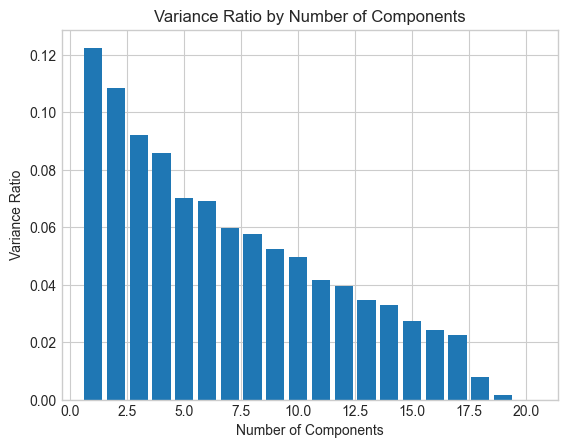

In [95]:
def plot_PCA_variance(pca, cumulative=True):
    # Assuming you have already performed PCA and stored it in the variable 'pca'
    variance_ratio = pca.explained_variance_ratio_

    if cumulative:
        cumulative_variance = np.cumsum(variance_ratio)
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, '*-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance')
        plt.title('Cumulative Variance by Number of Components')
        plt.show()
    else:
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Ratio')
        plt.title('Variance Ratio by Number of Components')
        plt.show()

plot_PCA_variance(pca, cumulative=False)

## Defining the model used

In [42]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(180, 90)
        self.fc2 = torch.nn.Linear(90, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        self.drop = torch.nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        return out


## Define function to reset weight
Weight resetting aid to prevent the weight leakage

In [43]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Loss function and optimizer

In [44]:
# Define the loss function 
criterion = torch.nn.MSELoss()

In [82]:
def peptides_to_pixel_encoding(peptides, aa_features_dict):
    
    encoded_peptides = []

    for peptide in peptides:
        encoded_peptide = []
    
        for aa in peptide:
            encoded_peptide.append(aa_features_dict[aa])
        
        encoded_peptide = np.array(encoded_peptide).flatten()
        encoded_peptides.append(encoded_peptide)

    return np.array(encoded_peptides)

encoded_peptides = peptides_to_pixel_encoding(peptides, aa_features_dict)

In [68]:
encoded_peptides_tensor = torch.tensor(encoded_peptides, dtype=torch.float32).to(device)
PSSM_score_tensor = torch.tensor(np.asarray(PSSM_score).reshape(-1,1), dtype=torch.float32).to(device)
peptides_dataset = TensorDataset(encoded_peptides_tensor, PSSM_score_tensor)

In [69]:
def plot_loss(train_loss, val_loss, fold):
    plt.figure()
    plt.plot(train_loss, label='train err')
    plt.plot(val_loss, label='val err')
    plt.legend()
    plt.yscale('log')
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./loss/pixel_loss_fold_{fold}.png')
    plt.close()

In [70]:
torch.manual_seed(69)

kfold = KFold(n_splits=5, shuffle=True)

print("Starting KFold Cross Validation")

for fold, (train_ids, test_ids) in enumerate(kfold.split(peptides_dataset), 1):
    
    print(f'Fold {fold}')

    # Shuffle the data
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define the data loaders
    train_loader = DataLoader(peptides_dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(peptides_dataset, batch_size=10, sampler=test_subsampler)

    # Initialize NN
    model = Linear_NN().to(device)
    model.apply(reset_weights)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    training_losses = []
    validation_losses = []

    for epoch in range(0, 100):
    
            print(f'Epoch {epoch+1}')

            training_loss = 0.0

            for i, data in enumerate(train_loader):
                  
                # Get the inputs
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs.view(-1, 180))

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                training_loss += loss.item()
            
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0

                for inputs, labels in test_loader:

                    outputs = model(inputs.view(-1, 180))
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()

            training_losses.append(training_loss/len(train_loader))
            validation_losses.append(validation_loss/len(test_loader))

            print(f'Training loss: {training_loss/len(train_loader)}')
            print(f'Validation Loss: {validation_loss/len(test_loader)}')

            
    # Save the model
    print('Finished Training, Saving Model')
    torch.save(model.state_dict(), f'./model/pixel_model_fold_{fold}.pt')

    # Plot the loss
    plot_loss(training_losses, validation_losses, fold) 
  
    

Starting KFold Cross Validation
Fold 1
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 11.167510915048343
Validation Loss: 2.96309627532959
Epoch 2
Training loss: 1.4756382399613095
Validation Loss: 1.283084750175476
Epoch 3
Training loss: 0.46903217530127655
Validation Loss: 1.0465771120786667
Epoch 4
Training loss: 0.20037506082930515
Validation Loss: 0.9041767501831055
Epoch 5
Training loss: 0.10480024271942291
Validation Loss: 0.8625803458690643
Epoch 6
Training loss: 0.053880125812264444
Validation Loss: 0.8328930842876434
Epoch 7
Training loss: 0.032271926891365925
Validation Loss: 0.8456675630807876
Epoch 8
Training loss: 0.017895250336372667
Validation Loss: 0.7996543222665786
Epoch 9
Training loss: 0.012885891365549844
Validation Loss: 0.825803479552269
Epoch 10
Training loss: 0.0084955

C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\981078898.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 2
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 11.605656498486233
Validation Loss: 3.567859869003296
Epoch 2
Training loss: 1.5210152517274482
Validation Loss: 1.527932596206665
Epoch 3
Training loss: 0.48641600160254644
Validation Loss: 1.279975745677948
Epoch 4
Training loss: 0.20901779452165992
Validation Loss: 1.140936814546585
Epoch 5
Training loss: 0.09961346039529313
Validation Loss: 1.0448041939735413
Epoch 6
Training loss: 0.05302605826945342
Validation Loss: 1.0221890377998353
Epoch 7
Training loss: 0.02807845117658684
Validation Loss: 1.0074192667007447
Epoch 8
Training loss: 0.01856177357342286
Validation Loss: 0.959728901386261
Epoch 9
Training loss: 0.012665332425817771
Validation Loss: 0.9777934265136718
Epoch 10
Training loss: 0.01118181789049053
Validation Loss: 0.941564

C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\981078898.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 3
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 13.0457228065766
Validation Loss: 3.742963614463806
Epoch 2
Training loss: 1.7267845630952992
Validation Loss: 1.696437073945999
Epoch 3
Training loss: 0.5616261441375792
Validation Loss: 1.3257163906097411
Epoch 4
Training loss: 0.24145975056075558
Validation Loss: 1.1772960114479065
Epoch 5
Training loss: 0.10589266664434954
Validation Loss: 1.1536743664741516
Epoch 6
Training loss: 0.05153801041588034
Validation Loss: 1.1902538204193116
Epoch 7
Training loss: 0.02932114512947647
Validation Loss: 1.107835859656334
Epoch 8
Training loss: 0.015219484955149213
Validation Loss: 1.1730340552330016
Epoch 9
Training loss: 0.010796557430216331
Validation Loss: 1.0772026532888412
Epoch 10
Training loss: 0.0086197785831527
Validation Loss: 1.0621271

C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\981078898.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 4
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 12.933480863718643
Validation Loss: 3.8104119539260863
Epoch 2
Training loss: 1.6060705953037615
Validation Loss: 1.8896645379066468
Epoch 3
Training loss: 0.48648793042935046
Validation Loss: 1.399090319275856
Epoch 4
Training loss: 0.22301183087924092
Validation Loss: 1.2815940880775452
Epoch 5
Training loss: 0.10611743445402567
Validation Loss: 1.1970522356033326
Epoch 6
Training loss: 0.05149959197709548
Validation Loss: 1.2674184918403626
Epoch 7
Training loss: 0.030605321231576586
Validation Loss: 1.2136317372322083
Epoch 8
Training loss: 0.017065211492062537
Validation Loss: 1.2099542152881622
Epoch 9
Training loss: 0.009614539860757356
Validation Loss: 1.1856671750545502
Epoch 10
Training loss: 0.008563667104925154
Validation Loss: 1

C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\981078898.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 5
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 11.651583090270918
Validation Loss: 3.185941195487976
Epoch 2
Training loss: 1.5375596023711962
Validation Loss: 1.6365652179718018
Epoch 3
Training loss: 0.44782478554347127
Validation Loss: 1.2426080572605134
Epoch 4
Training loss: 0.19804781537080549
Validation Loss: 1.103765807747841
Epoch 5
Training loss: 0.10314640661067877
Validation Loss: 1.1878377425670623
Epoch 6
Training loss: 0.052242976210089685
Validation Loss: 1.0223542296886443
Epoch 7
Training loss: 0.027685464885489074
Validation Loss: 1.0086483204364776
Epoch 8
Training loss: 0.018037793586587476
Validation Loss: 0.9642377019301057
Epoch 9
Training loss: 0.012034928944614744
Validation Loss: 0.9456963508948684
Epoch 10
Training loss: 0.010904431549505782
Validation Loss: 0

C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\981078898.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Evaluating the model with unseen data

In [83]:
evaluation_data = './data/evaluation_peptide_PSSM_scores.txt'
# evaluation_data = '../data/data/PSSM/A0201.eval'
evaluation_peptides, evaluation_score = load_peptide_data(evaluation_data)
encoded_evaluation_peptides = peptides_to_pixel_encoding(evaluation_peptides, aa_features_dict)

# Convert to tensors
evaluation_peptides_tensor = torch.tensor(encoded_evaluation_peptides, dtype=torch.float32).to(device)
evaluation_score_tensor = torch.tensor(np.asarray(evaluation_score).reshape(-1,1), dtype=torch.float32).to(device)

evaluation_peptides_dataset = TensorDataset(evaluation_peptides_tensor, evaluation_score_tensor)


def test_model(models, evaluation_peptides_dataset):
    predictions = []

    evaluation_data_loader = DataLoader(evaluation_peptides_dataset, batch_size=10)

    with torch.no_grad():
        for model in models:
            model.eval()
            model_predictions = []

            for peptides, _ in evaluation_data_loader:
                peptides = peptides.to(device)
                outputs = model(peptides.view(-1, 180))
                model_predictions.extend(outputs.cpu().numpy())

            predictions.append(model_predictions)

    # Average predictions across models
    averaged_predictions = np.mean(predictions, axis=0)

    # Calculate total loss
    total_loss = criterion(torch.tensor(averaged_predictions, dtype=torch.float32).to(device), evaluation_score_tensor).item()

    return averaged_predictions, total_loss

# Load models
models = []
for i in range(1,6):
    model = Linear_NN().to(device)
    model.load_state_dict(torch.load(f'./model/pixel_model_fold_{i}.pt'))
    models.append(model)

# Test models
predictions, total_loss = test_model(models, evaluation_peptides_dataset)

print(f'Total Loss: {total_loss}')

Total Loss: 0.1944684237241745


## Saving evaluation data prediction result

In [84]:
outfile = './evaluation_result/pixel_evaluation_predictions.txt'

with open(outfile, 'w') as f:
    print('Peptide      Score      Prediction', file=f)
    for peptide, score, prediction in zip(evaluation_peptides, evaluation_score, predictions):
        print(f'{"".join(peptide):<12} {score:<10.4f} {prediction[0]:<10.4f}', file=f)

PCC:  0.9960347730845701


C:\Users\Chuan\AppData\Local\Temp\ipykernel_28408\1938743911.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid');


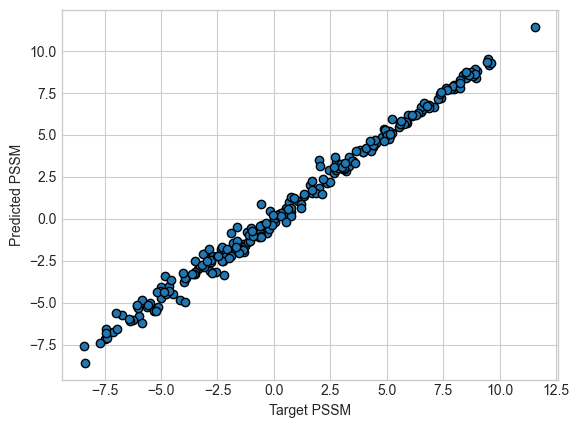

In [85]:
pcc = pearsonr(evaluation_score, np.array(predictions).flatten())
print("PCC: ", pcc[0])

plt.figure()
plt.style.use('seaborn-whitegrid');
plt.scatter(evaluation_score, predictions, edgecolors='black');
plt.xlabel('Target PSSM');
plt.ylabel('Predicted PSSM');
plt.savefig('./evaluation_result/pixel_evaluation_scatter.png')